# Feature engineering

An online merchant asks you to make real-time predictions for the customers of his 
website: when they are ready to buy, tell them the date of receipt of their product, for 
the various possible transport services.

To do this, you have 6 weeks of order history with 3 pieces of information
- Date and time of the customer's order
- Shipment date (to simplify considered as order shipment date)
- Transport service
In production
- You will have a daily update (every night) of the warehouse status (this same updated 
file)
- You will need to be able to deliver real-time on-the-fly prediction with each new online 
order. The speed of your predictive model will be as important as its accuracy

## Data visualisation

### Data import

In [ ]:
# import librairies and dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

dataset = pd.read_csv('./datasets/logistique.csv')
dataset

,datedecreationdecommande,providerservice_id,dateexpe
0,2019-11-01 11:40:35.9930000,48,02/11/2019
1,2019-11-01 11:40:35.9700000,48,02/11/2019
2,2019-11-01 10:24:40.8930000,48,02/11/2019
3,2019-11-01 14:24:21.1770000,48,02/11/2019
4,2019-11-01 13:28:35.7900000,48,02/11/2019
...,...,...,...
572836,2019-12-16 06:12:25.2170000,48,17/12/2019
572837,2019-12-16 06:12:25.4630000,48,17/12/2019
572838,2019-12-15 22:32:36.3200000,48,17/12/2019
572839,2019-12-15 20:06:55.0670000,48,17/12/2019


In [ ]:
dataset.dtypes

datedecreationdecommande    object
providerservice_id           int64
dateexpe                    object
dtype: object

### Data cleaning

In [ ]:
# Seperate date and time of creation date
order_fulldate = pd.to_datetime(dataset['datedecreationdecommande'], format='%Y-%m-%d')
order_date = order_fulldate.dt.date.astype('datetime64')
order_time = order_fulldate.dt.floor('H').astype('datetime64').dt.time

In [ ]:
# Format expedition date 
expedition_date = pd.to_datetime(dataset['dateexpe'], format='%d/%m/%Y').astype('datetime64')
expedition_date

0        2019-11-02
1        2019-11-02
2        2019-11-02
3        2019-11-02
4        2019-11-02
            ...    
572836   2019-12-17
572837   2019-12-17
572838   2019-12-17
572839   2019-12-17
572840   2019-12-17
Name: dateexpe, Length: 572841, dtype: datetime64[ns]

In [ ]:
# Creating a new dataframe with desired values 

df = pd.DataFrame(columns=[
    'provider_id', 
    'order_date',
    'order_time',
    'order_stock', 
    'expedition_date', 
    'delay'])

df['provider_id'] = dataset['providerservice_id'].astype('category')
df['order_date'] = order_date
df['order_time'] = order_time
df['expedition_date'] = expedition_date
df['delay'] = (df['expedition_date'] - df['order_date']).astype('timedelta64[D]')
df['delay'] = df['delay'].astype('int8')
df['order_stock'] = df.groupby('order_date')['order_date'].transform('size')

In [ ]:
df

,provider_id,order_date,order_time,order_stock,expedition_date,delay
0,48,2019-11-01,11:00:00,2641,2019-11-02,1
1,48,2019-11-01,11:00:00,2641,2019-11-02,1
2,48,2019-11-01,10:00:00,2641,2019-11-02,1
3,48,2019-11-01,14:00:00,2641,2019-11-02,1
4,48,2019-11-01,13:00:00,2641,2019-11-02,1
...,...,...,...,...,...,...
572836,48,2019-12-16,06:00:00,1286,2019-12-17,1
572837,48,2019-12-16,06:00:00,1286,2019-12-17,1
572838,48,2019-12-15,22:00:00,12223,2019-12-17,2
572839,48,2019-12-15,20:00:00,12223,2019-12-17,2


In [ ]:
df = df[df['delay'] >= 0]
df

,provider_id,order_date,order_time,order_stock,expedition_date,delay
0,48,2019-11-01,11:00:00,2641,2019-11-02,1
1,48,2019-11-01,11:00:00,2641,2019-11-02,1
2,48,2019-11-01,10:00:00,2641,2019-11-02,1
3,48,2019-11-01,14:00:00,2641,2019-11-02,1
4,48,2019-11-01,13:00:00,2641,2019-11-02,1
...,...,...,...,...,...,...
572836,48,2019-12-16,06:00:00,1286,2019-12-17,1
572837,48,2019-12-16,06:00:00,1286,2019-12-17,1
572838,48,2019-12-15,22:00:00,12223,2019-12-17,2
572839,48,2019-12-15,20:00:00,12223,2019-12-17,2


### Data analysis

In [ ]:
# Historique des commande : stock a traiter par date (genre le 1er octobre, le 1er novembre.... )
# Nombre de commande par provider
# Nombre de commande par date/par jour et par provider
# Heures de commandes / jour de la semaine

In [ ]:
df['order_stock'].groupby(pd.to_datetime(df['order_date']).dt.month).sum()

order_date
11    5214968117
12    5176291614
Name: order_stock, dtype: int64

In [ ]:
# Average delay and stock per month
df.groupby(pd.to_datetime(df['order_date']).dt.month).mean().reset_index(level=0)

,order_date,order_stock,delay
0,11,15487.550835,1.921401
1,12,21922.477803,2.882703


In [ ]:
# Delay and stock evolution per day
delay_stock_evolution = df.groupby(pd.to_datetime(df['order_date'])).mean().reset_index(level=0)

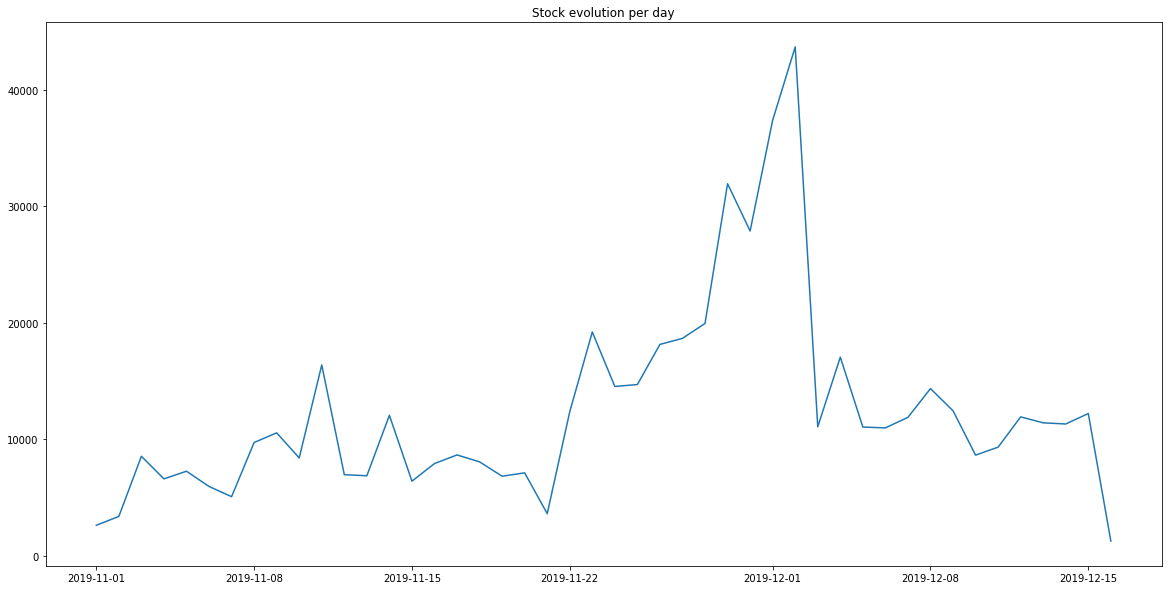

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot('order_date', 'order_stock', data=delay_stock_evolution)
plt.title('Stock evolution per day')
plt.show()

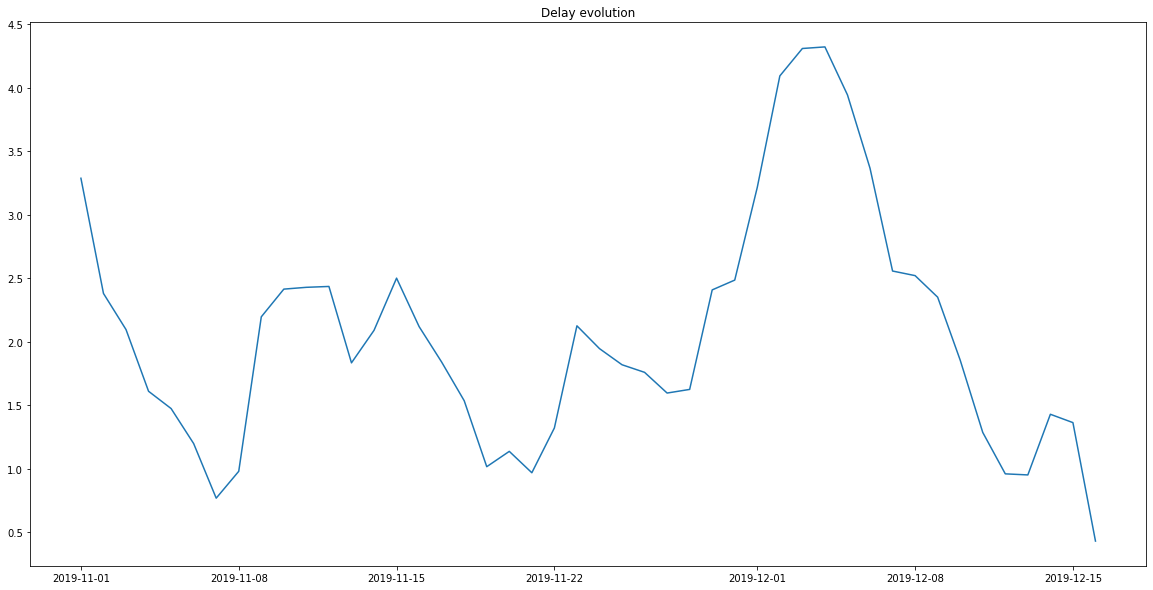

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot('order_date', 'delay', data=delay_stock_evolution)
plt.title('Delay evolution')
plt.show()

In [ ]:
df.groupby('provider_id')['delay'].describe()[['count', 'mean', 'min', 'max']].rename(columns={'count': 'nb_deliveries', 'mean': 'mean_delay', 'min': 'min_delay', 'max': 'max_delay'})

,nb_deliveries,mean_delay,min_delay,max_delay
provider_id,,,,
5,18.0,2.888889,1.0,5.0
7,36361.0,2.998735,0.0,8.0
16,10019.0,0.680208,0.0,4.0
20,400.0,0.730000,0.0,5.0
21,75872.0,1.893373,0.0,11.0
42,5647.0,3.390827,0.0,7.0
48,442881.0,2.366358,0.0,15.0
92,1640.0,0.377439,0.0,3.0


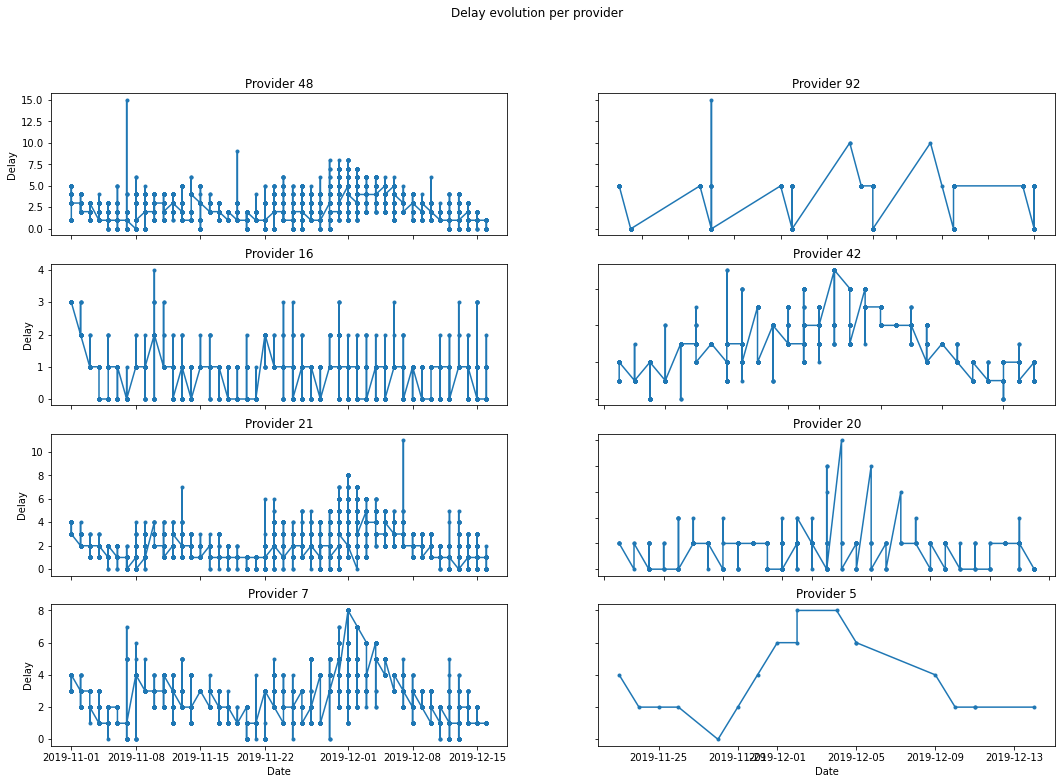

In [ ]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(18, 12)
fig.suptitle('Delay evolution per provider')

iterator = 0
for provider in df['provider_id'].unique():
    ax_x_index = iterator % 4
    ax_y_index = iterator // 4

    iterator += 1

    provider_data = df[df['provider_id'] == provider].sort_values('order_date')

    axs[ax_x_index, ax_y_index].plot('order_date', 'delay', data=provider_data, marker='.')
    axs[ax_x_index, ax_y_index].set_title(f'Provider {provider}')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Delay')

for ax in axs.flat:
    ax.label_outer()

#### Order hours

In [ ]:
time_12 = datetime.datetime.strptime('12:00', '%H:%M').time()
time_18 = datetime.datetime.strptime('18:00', '%H:%M').time()

# Order taken before 12pm
order_before_12 = df[df['order_time'] < time_12]

# Order taken between 12pm & 6pm
order_between_12_18 = df[(df['order_time'] >= time_12) & (df['order_time'] < time_18)]

# Order taken after 6pm
order_after_18 = df[df['order_time'] >= time_18]

In [ ]:
print('-- Order done before 12\n')
print('Mean delay:', order_before_12['delay'].mean())
print('Minimum delay:', order_before_12['delay'].min())
print('Maximum delay:', order_before_12['delay'].max())

-- Order done before 12

Mean delay: 2.0572830323939244
Minimum delay: 0
Maximum delay: 15


In [ ]:
print('-- Order done between 12 and 18\n')
print('Mean delay:', order_between_12_18['delay'].mean())
print('Minimum delay:', order_between_12_18['delay'].min())
print('Maximum delay:', order_between_12_18['delay'].max())

-- Order done between 12 and 18

Mean delay: 2.2452033388291714
Minimum delay: 0
Maximum delay: 8


In [ ]:
print('-- Order done after 18\n')
print('Mean delay:', order_after_18['delay'].mean())
print('Minimum delay:', order_after_18['delay'].min())
print('Maximum delay:', order_after_18['delay'].max())

-- Order done after 18

Mean delay: 2.5678105959046977
Minimum delay: 0
Maximum delay: 11


In [ ]:
order_period_conditions = [
    (df['order_time'] < time_12),
    (df['order_time'] >= time_12) & (df['order_time'] < time_18),
    (df['order_time'] >= time_18)
]

order_period_values = [
    'before_12',
    'between_12_18',
    'after_18'
]

df.loc[:, 'order_period'] = np.select(order_period_conditions, order_period_values)
df.loc[:, 'order_period'] = df.loc[:, 'order_period'].astype('category')

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
df['is_week_day'] = np.where(df['order_date'].dt.dayofweek > 4, 0, 1)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Data prediction

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

print(tf.__version__)

2021-10-09 21:56:31.413190: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-09 21:56:31.413263: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2.4.1


In [ ]:
tmp_df = pd.get_dummies(
    df, columns=['provider_id', 'order_period'], 
    prefix=['provider', ''], 
    prefix_sep=['_', ''])

tmp_df

,order_date,order_time,order_stock,expedition_date,delay,is_week_day,provider_5,provider_7,provider_16,provider_20,provider_21,provider_42,provider_48,provider_92,after_18,before_12,between_12_18
0,2019-11-01,11:00:00,2641,2019-11-02,1,1,0,0,0,0,0,0,1,0,0,1,0
1,2019-11-01,11:00:00,2641,2019-11-02,1,1,0,0,0,0,0,0,1,0,0,1,0
2,2019-11-01,10:00:00,2641,2019-11-02,1,1,0,0,0,0,0,0,1,0,0,1,0
3,2019-11-01,14:00:00,2641,2019-11-02,1,1,0,0,0,0,0,0,1,0,0,0,1
4,2019-11-01,13:00:00,2641,2019-11-02,1,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572836,2019-12-16,06:00:00,1286,2019-12-17,1,1,0,0,0,0,0,0,1,0,0,1,0
572837,2019-12-16,06:00:00,1286,2019-12-17,1,1,0,0,0,0,0,0,1,0,0,1,0
572838,2019-12-15,22:00:00,12223,2019-12-17,2,0,0,0,0,0,0,0,1,0,1,0,0
572839,2019-12-15,20:00:00,12223,2019-12-17,2,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
# select the columns for predictions
tmp_df = pd.concat([
    tmp_df.loc[:, ['delay', 'order_stock', 'is_week_day']],
    tmp_df.iloc[:, 6:]
], axis = 1)

tmp_df

,delay,order_stock,is_week_day,provider_5,provider_7,provider_16,provider_20,provider_21,provider_42,provider_48,provider_92,after_18,before_12,between_12_18
0,1,2641,1,0,0,0,0,0,0,1,0,0,1,0
1,1,2641,1,0,0,0,0,0,0,1,0,0,1,0
2,1,2641,1,0,0,0,0,0,0,1,0,0,1,0
3,1,2641,1,0,0,0,0,0,0,1,0,0,0,1
4,1,2641,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572836,1,1286,1,0,0,0,0,0,0,1,0,0,1,0
572837,1,1286,1,0,0,0,0,0,0,1,0,0,1,0
572838,2,12223,0,0,0,0,0,0,0,1,0,1,0,0
572839,2,12223,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
train_data, test_data = train_test_split(tmp_df, test_size=0.2)

In [ ]:
X_train = train_data.iloc[:, 1:]
y_train = train_data.loc[:, 'delay']

X_test = test_data.iloc[:, 1:]
y_test = test_data.loc[:, 'delay']

In [ ]:
# model = keras.Sequential([
#     keras.layers.Dense(8, activation='relu'),
#     #keras.layers.Dropout(0.2),
#     keras.layers.Dense(8, activation='relu'),
#     #keras.layers.Dropout(0.2),
#     keras.layers.Dense(15, activation='softmax')
# ])
# 
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=10, verbose=1)

In [ ]:
model = linear_model.LinearRegression() 
scores = cross_val_score(model, X_train, y_train, scoring='r2')

# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
print('R²:', scores)

R²: [0.29265213 0.29310007 0.29386022 0.29457849 0.29109619]


In [ ]:
# model = make_pipeline(
#     PolynomialFeatures(3),
#     linear_model.LinearRegression()
# )

# model.fit(X_train, y_train)
# model.score(X_test, y_test)

0.32362085827798825

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

### Another way to split the data : train in november, test in december

In [ ]:
# In order to verify if the split vas correctly done we first check the count for each month

df.groupby([pd.to_datetime(df['order_date']).dt.month == 12]).size().reset_index(name='counts')

In [ ]:
november = tmp_df[pd.to_datetime(df['order_date']).dt.month == 11]
december = tmp_df[pd.to_datetime(df['order_date']).dt.month == 12]

In [ ]:
november = pd.concat([
    november.loc[:, ['delay', 'order_stock', 'is_week_day']], 
    november.iloc[:, -3:]
], axis = 1)

december = pd.concat([
    december.loc[:, ['delay', 'order_stock', 'is_week_day']], 
    december.iloc[:, -3:]
], axis = 1)

In [ ]:
X_train, y_train, X_test, y_test = november.iloc[:, 1:], november.loc[:, 'delay'], december.iloc[:, 1:], december.loc[:, 'delay']

In [ ]:
X_train, y_train, X_test, y_test

In [ ]:
model = linear_model.LinearRegression() 
scores = cross_val_score(model, X_train, y_train, scoring='r2')

# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
print('R²:', scores)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e4a7d48e-7d58-47a1-84ae-2aa4b9c77080' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>